In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from nnfabrik.builder import get_data, get_model, get_trainer
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

## Load Models

In [2]:
seed=31415
autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
sens1_dataPath = "../data/sensorium_data2022/static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"
sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

In [3]:
dataset_fn = 'sensorium.datasets.static_loaders'

filenames_autistic = [autistic_mouse_dataPath, ]

dataset_config_autistic = {'paths': filenames_autistic,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':1,
                 }

dataloaders_autistic = get_data(dataset_fn, dataset_config_autistic)

filenames_wildtype = [wildtype_mouse_dataPath, ]

dataset_config_wildtype = {'paths': filenames_wildtype,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':1,
                 }

dataloaders_wildtype = get_data(dataset_fn, dataset_config_wildtype)

filenames_sens1 = [sens1_dataPath, ]

dataset_config_sens1 = {'paths': filenames_sens1,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':0.25,
                 }

dataloaders_sens1 = get_data(dataset_fn, dataset_config_sens1)

filenames_sens2 = [sens2_dataPath, ]

dataset_config_sens2 = {'paths': filenames_sens2,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':0.25,
                 }

dataloaders_sens2 = get_data(dataset_fn, dataset_config_sens2)

In [4]:
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'stack': -1,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 0.0076,
  'hidden_kern': 7,
  'hidden_channels': 64,
  'depth_separable': True,
  'grid_mean_predictor': {'type': 'cortex',
   'input_dimensions': 2,
   'hidden_layers': 1,
   'hidden_features': 30,
   'final_tanh': True},
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': False,
}

model_a = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_autistic,
                  seed=seed,
                  )
model_awt = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_wildtype,
                  seed=seed,
                  )
model_wta = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_autistic,
                  seed=seed,
                  )
model_wt = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_wildtype,
                  seed=seed,
                  )
model_sens1= get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_sens1,
                  seed=seed,
                  )
model_sens2= get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_sens2,
                  seed=seed,
                  )
model_sa = get_model(model_fn=model_fn,
                    model_config=model_config,
                    dataloaders=dataloaders_autistic,
                    seed=seed,
                    )

In [5]:
model_a.load_state_dict(torch.load("./model_checkpoints/autistic_model.pth"))
model_awt.load_state_dict(torch.load("./model_checkpoints/autistic_core_wildtype_readout.pth"))
model_wta.load_state_dict(torch.load("./model_checkpoints/wildtype_core_autistic_readout.pth"))
model_wt.load_state_dict(torch.load("./model_checkpoints/wildtype_model.pth"))
model_sa.load_state_dict(torch.load("./model_checkpoints/sensoriumI_core_autistic_readout.pth"))
model_sens1.load_state_dict(torch.load("./model_checkpoints/sensorium22846-10-16.pth"))
model_sens2.load_state_dict(torch.load("./model_checkpoints/sensorium23964-4-22.pth"))

<All keys matched successfully>

In [6]:
model_a.eval()
model_awt.eval()
model_wta.eval()
model_wt.eval()
model_sa.eval()
model_sens1.eval()
model_sens2.eval()

FiringRateEncoder(
  (core): Stacked2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64, bias=False)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): 

## 

## Evaluation

In [7]:
data_key_aut = "29027-6-17-1-6-5"
data_key_wt = "29028-1-17-1-6-5"
data_key_sens1 = "22846-10-16"
data_key_sens2 = "23964-4-22"

## Calculating the single-trial-correlation for all models of the cross comparison experiment.

In [8]:
single_trial_correlation_awt = get_correlations(model_awt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
single_trial_correlation_wta = get_correlations(model_wta, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
single_trial_correlation_wt = get_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
single_trial_correlation_a = get_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
single_trial_correlation_sens1 = get_correlations(model_sens1, dataloaders_sens1, tier="test", device="cuda", as_dict=True)
single_trial_correlation_sens2 = get_correlations(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)
single_trial_correlation_sa = get_correlations(model_sa, dataloaders_autistic, tier="test", device="cuda", as_dict=True)

In [9]:
df_awt = get_df_for_scores(session_dict=single_trial_correlation_awt, measure_attribute="Single Trial Correlation")
df_awt["dataset"] = df_awt["dataset"].replace("29028-1-17-1-6-5", "Aut(C)-Wt(R)")
df_wta = get_df_for_scores(session_dict=single_trial_correlation_wta, measure_attribute="Single Trial Correlation")
df_wta["dataset"] = df_wta["dataset"].replace("29027-6-17-1-6-5", "Wt(C) - Aut(R)")
df_wt= get_df_for_scores(session_dict=single_trial_correlation_wt, measure_attribute="Single Trial Correlation")
df_wt["dataset"] = df_wt["dataset"].replace("29028-1-17-1-6-5", "Wt(C+R)")
df_a = get_df_for_scores(session_dict=single_trial_correlation_a, measure_attribute="Single Trial Correlation")
df_a["dataset"] = df_a["dataset"].replace("29027-6-17-1-6-5", "Aut(C+R)")
df_s1 = get_df_for_scores(session_dict=single_trial_correlation_sens1, measure_attribute="Single Trial Correlation")
df_s1["dataset"] = df_s1["dataset"].replace("22846-10-16", "SensI(C+R)")
df_s2 = get_df_for_scores(session_dict=single_trial_correlation_sens2, measure_attribute="Single Trial Correlation")
df_s2["dataset"] = df_s2["dataset"].replace("23964-4-22", "SensII(C+R)")
df_sa = get_df_for_scores(session_dict=single_trial_correlation_sa, measure_attribute="Single Trial Correlation")
df_sa["dataset"] = df_sa["dataset"].replace("29027-6-17-1-6-5", "SensI(C) - Aut(R)")
df = pd.concat([df_a, df_awt, df_wta, df_wt, df_s1, df_sa, df_s2])
df_ac = pd.concat([df_a, df_awt])
df_wc = pd.concat([df_wt, df_wta])
df_ar = pd.concat([df_a, df_wta, df_sa])

In [10]:
df.groupby("dataset").describe()

Single Trial Correlation                                \
                                     count      mean       std       min   
dataset                                                                    
Aut(C)-Wt(R)                        7497.0  0.217664  0.139460 -0.042424   
Aut(C+R)                            7744.0  0.297529  0.156137 -0.051231   
SensI(C) - Aut(R)                   7744.0  0.255013  0.147713 -0.034432   
SensI(C+R)                          7344.0  0.305670  0.124811  0.014886   
SensII(C+R)                         8098.0  0.275455  0.136094 -0.038504   
Wt(C) - Aut(R)                      7744.0  0.272710  0.149789 -0.021935   
Wt(C+R)                             7497.0  0.212808  0.141434 -0.044652   

                                                           
                        25%       50%       75%       max  
dataset                                                    
Aut(C)-Wt(R)       0.112544  0.192260  0.295030  0.793764  
Aut(C+R)           0.176774  0.280021  0.399051  0.842281  
SensI(C) - Aut(R)  0.142099  0.231345  0.346792  0.789632  
SensI(C+R)         0.215122  0.294158  0.385553  0.827552  
SensII(C+R)        0.175300  0.259316  0.359859  0.785926  
Wt(C) - Aut(R)     0.159019  0.251476  0.365295  0.824941  
Wt(C+R)            0.107549  0.185481  0.291395  0.820080

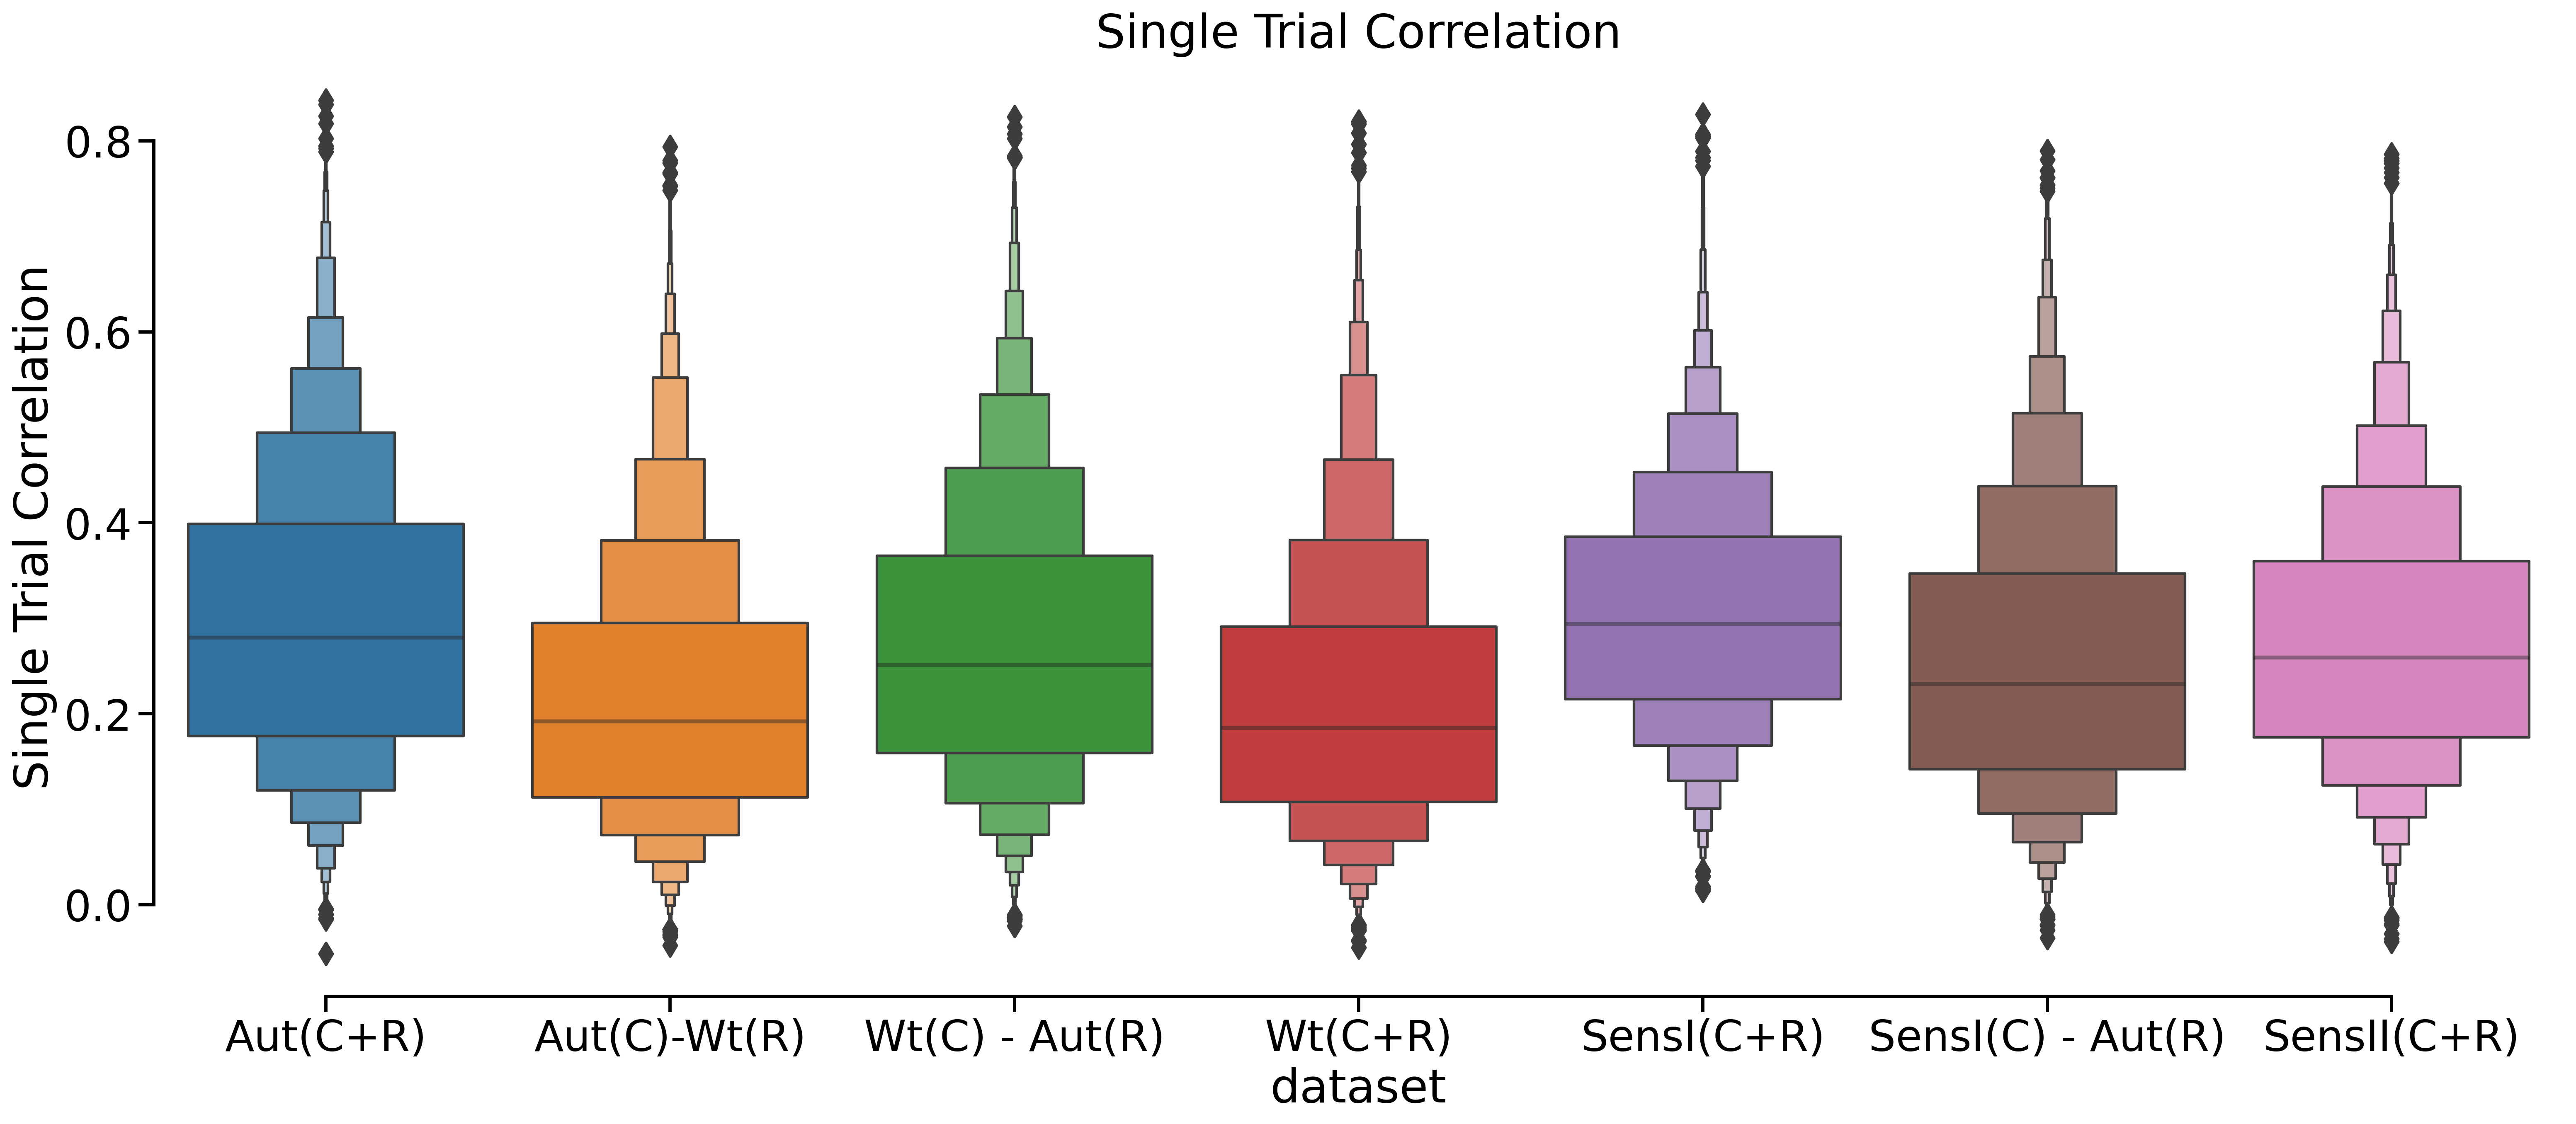

In [11]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.title("Single Trial Correlation")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonSTC.png", dpi=300)

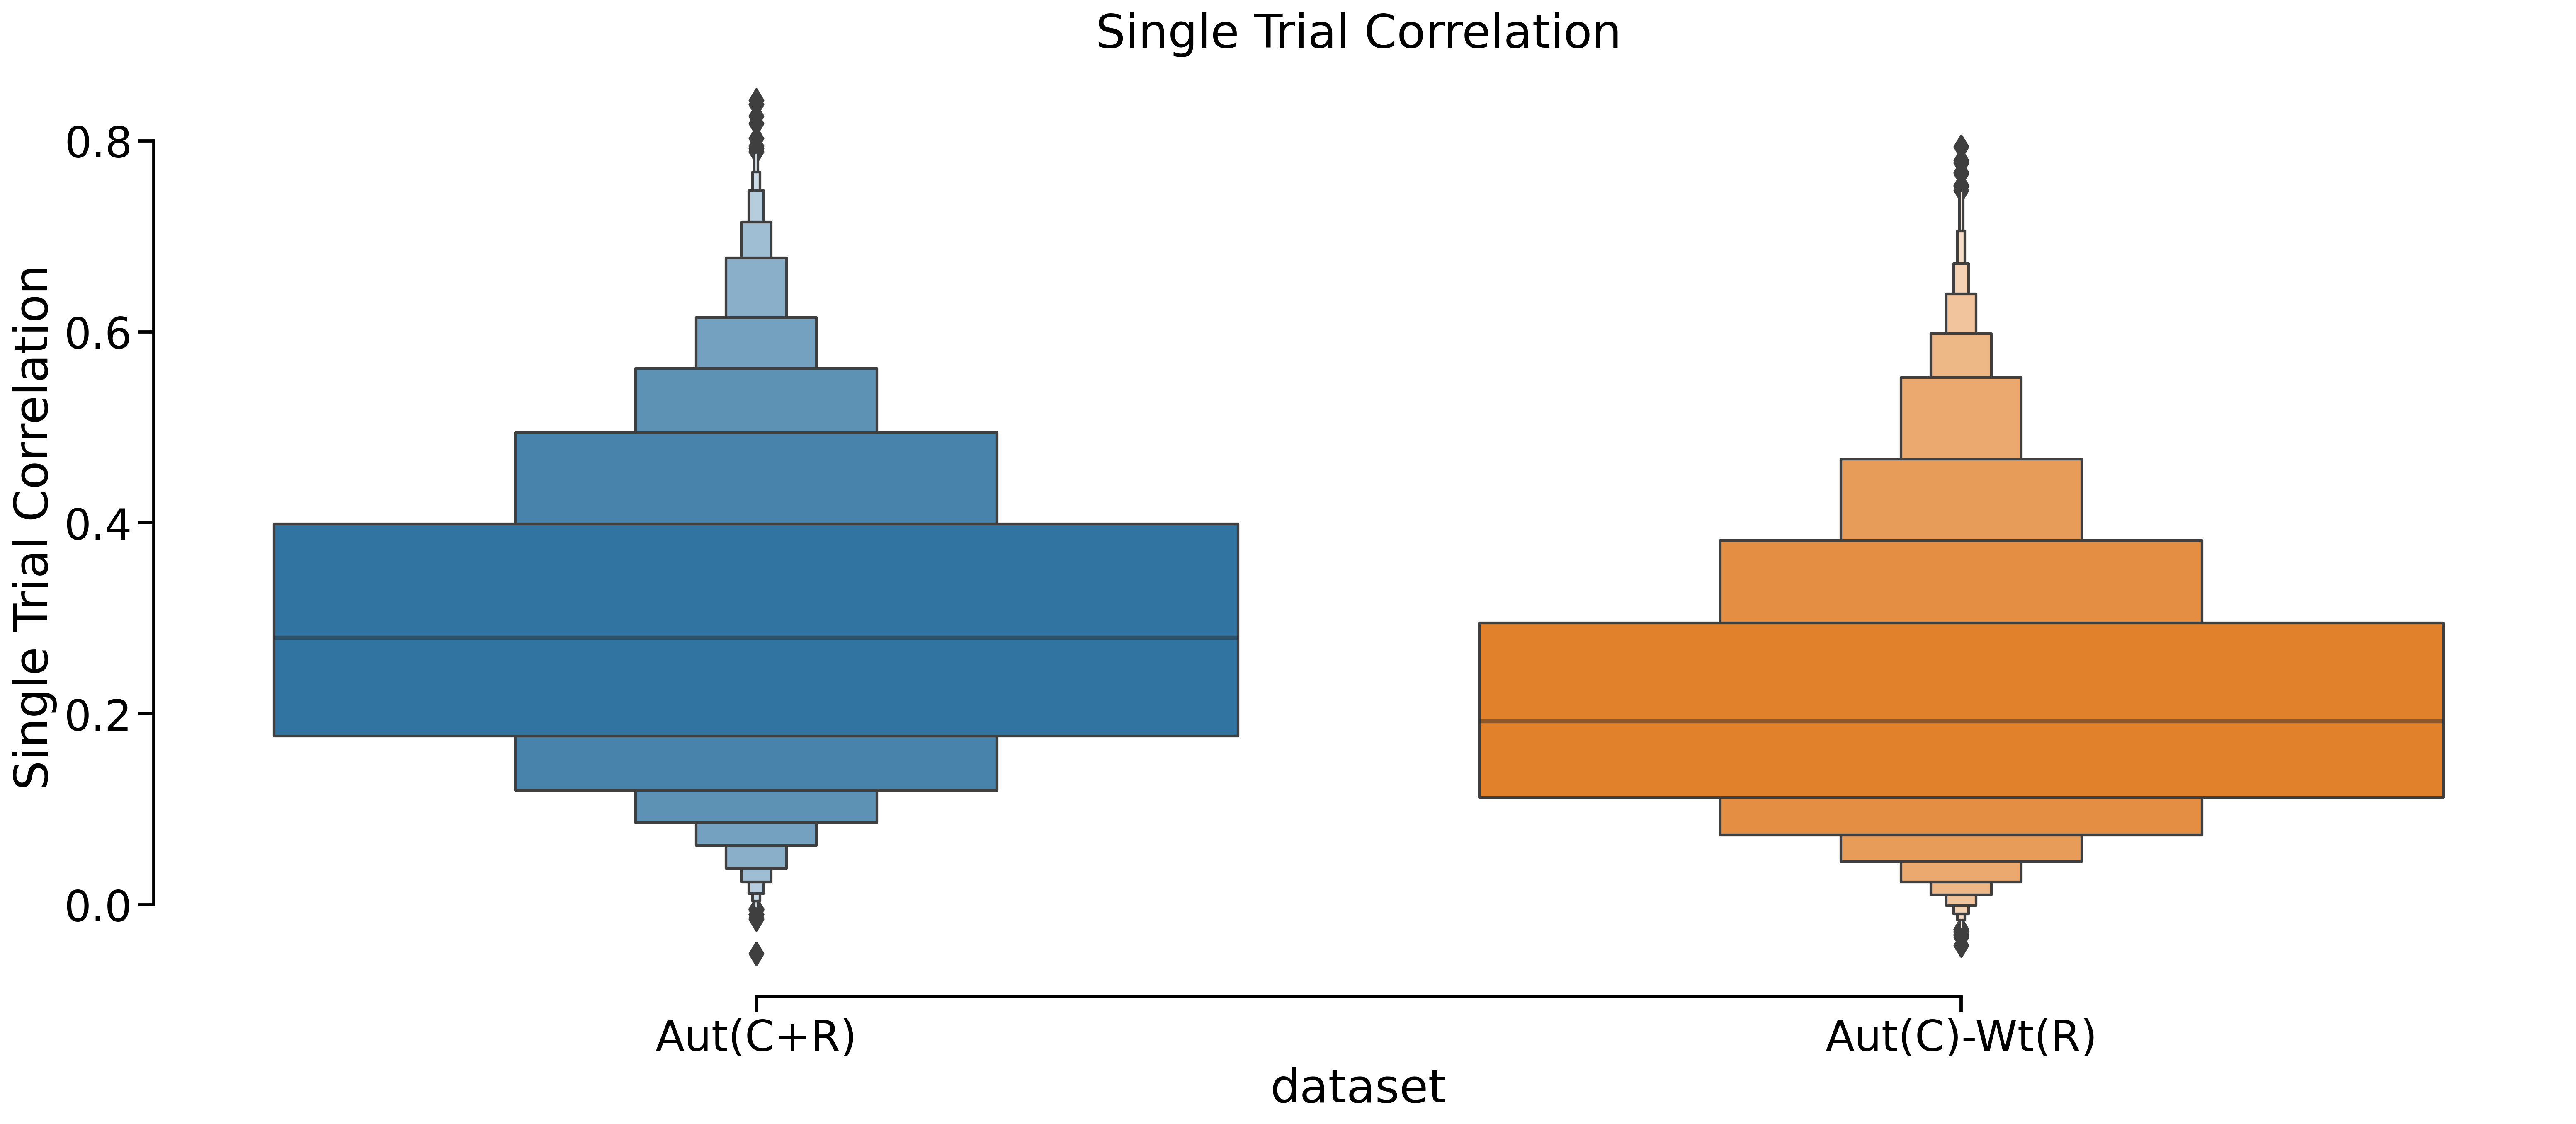

In [12]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df_ac, )
plt.title("Single Trial Correlation")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonSTCTAutC.png", dpi=300)

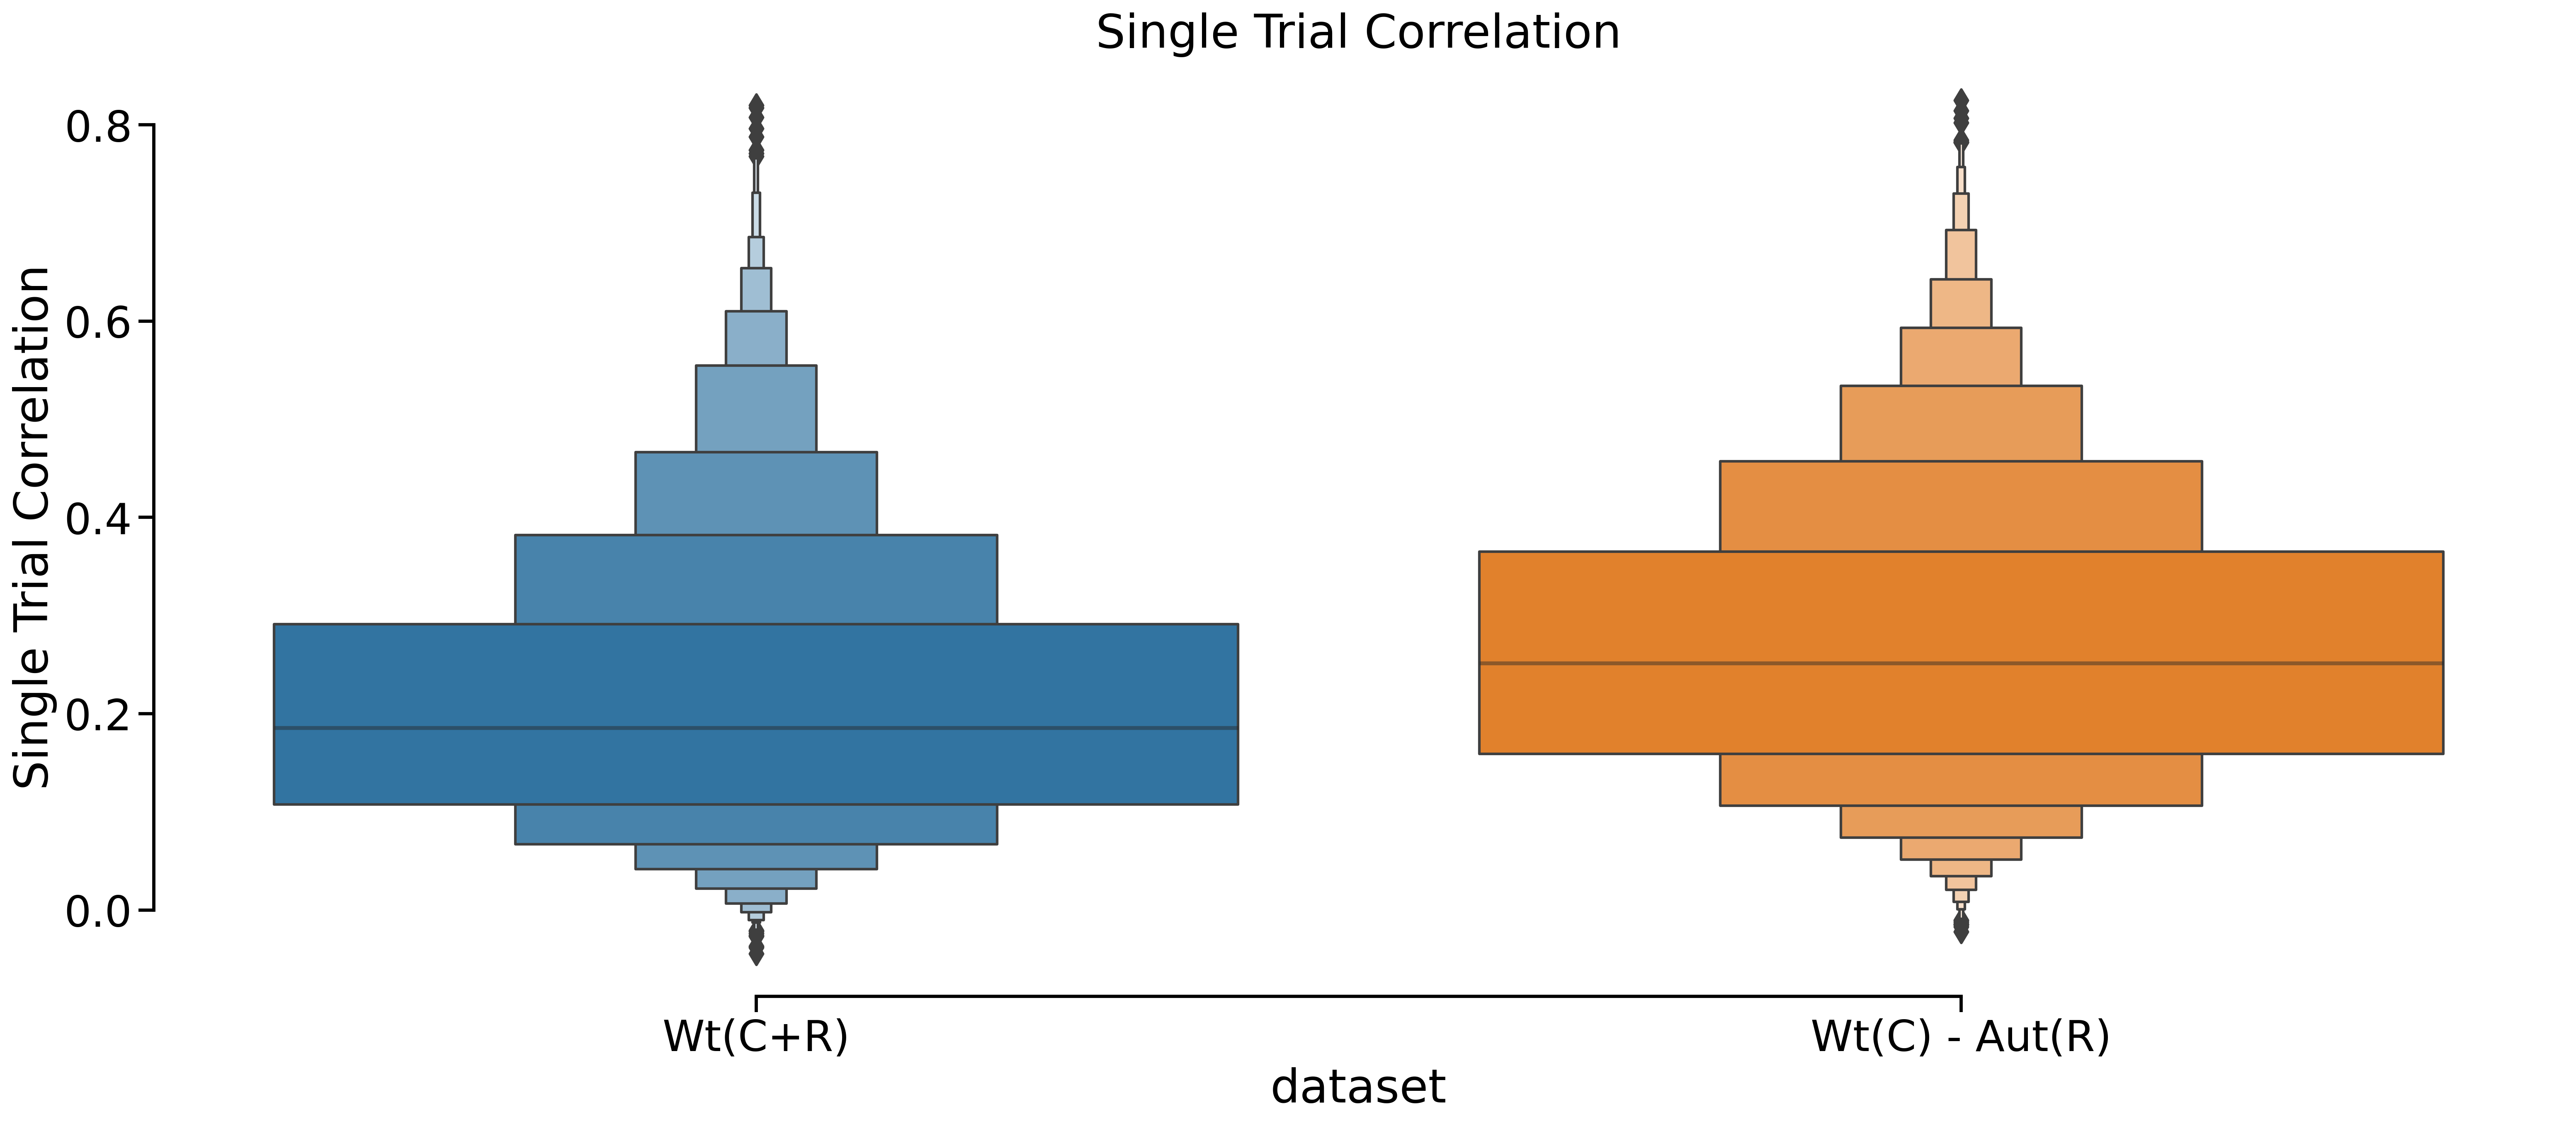

In [13]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df_wc, )
plt.title("Single Trial Correlation")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonSTCTWtC.png", dpi=300)

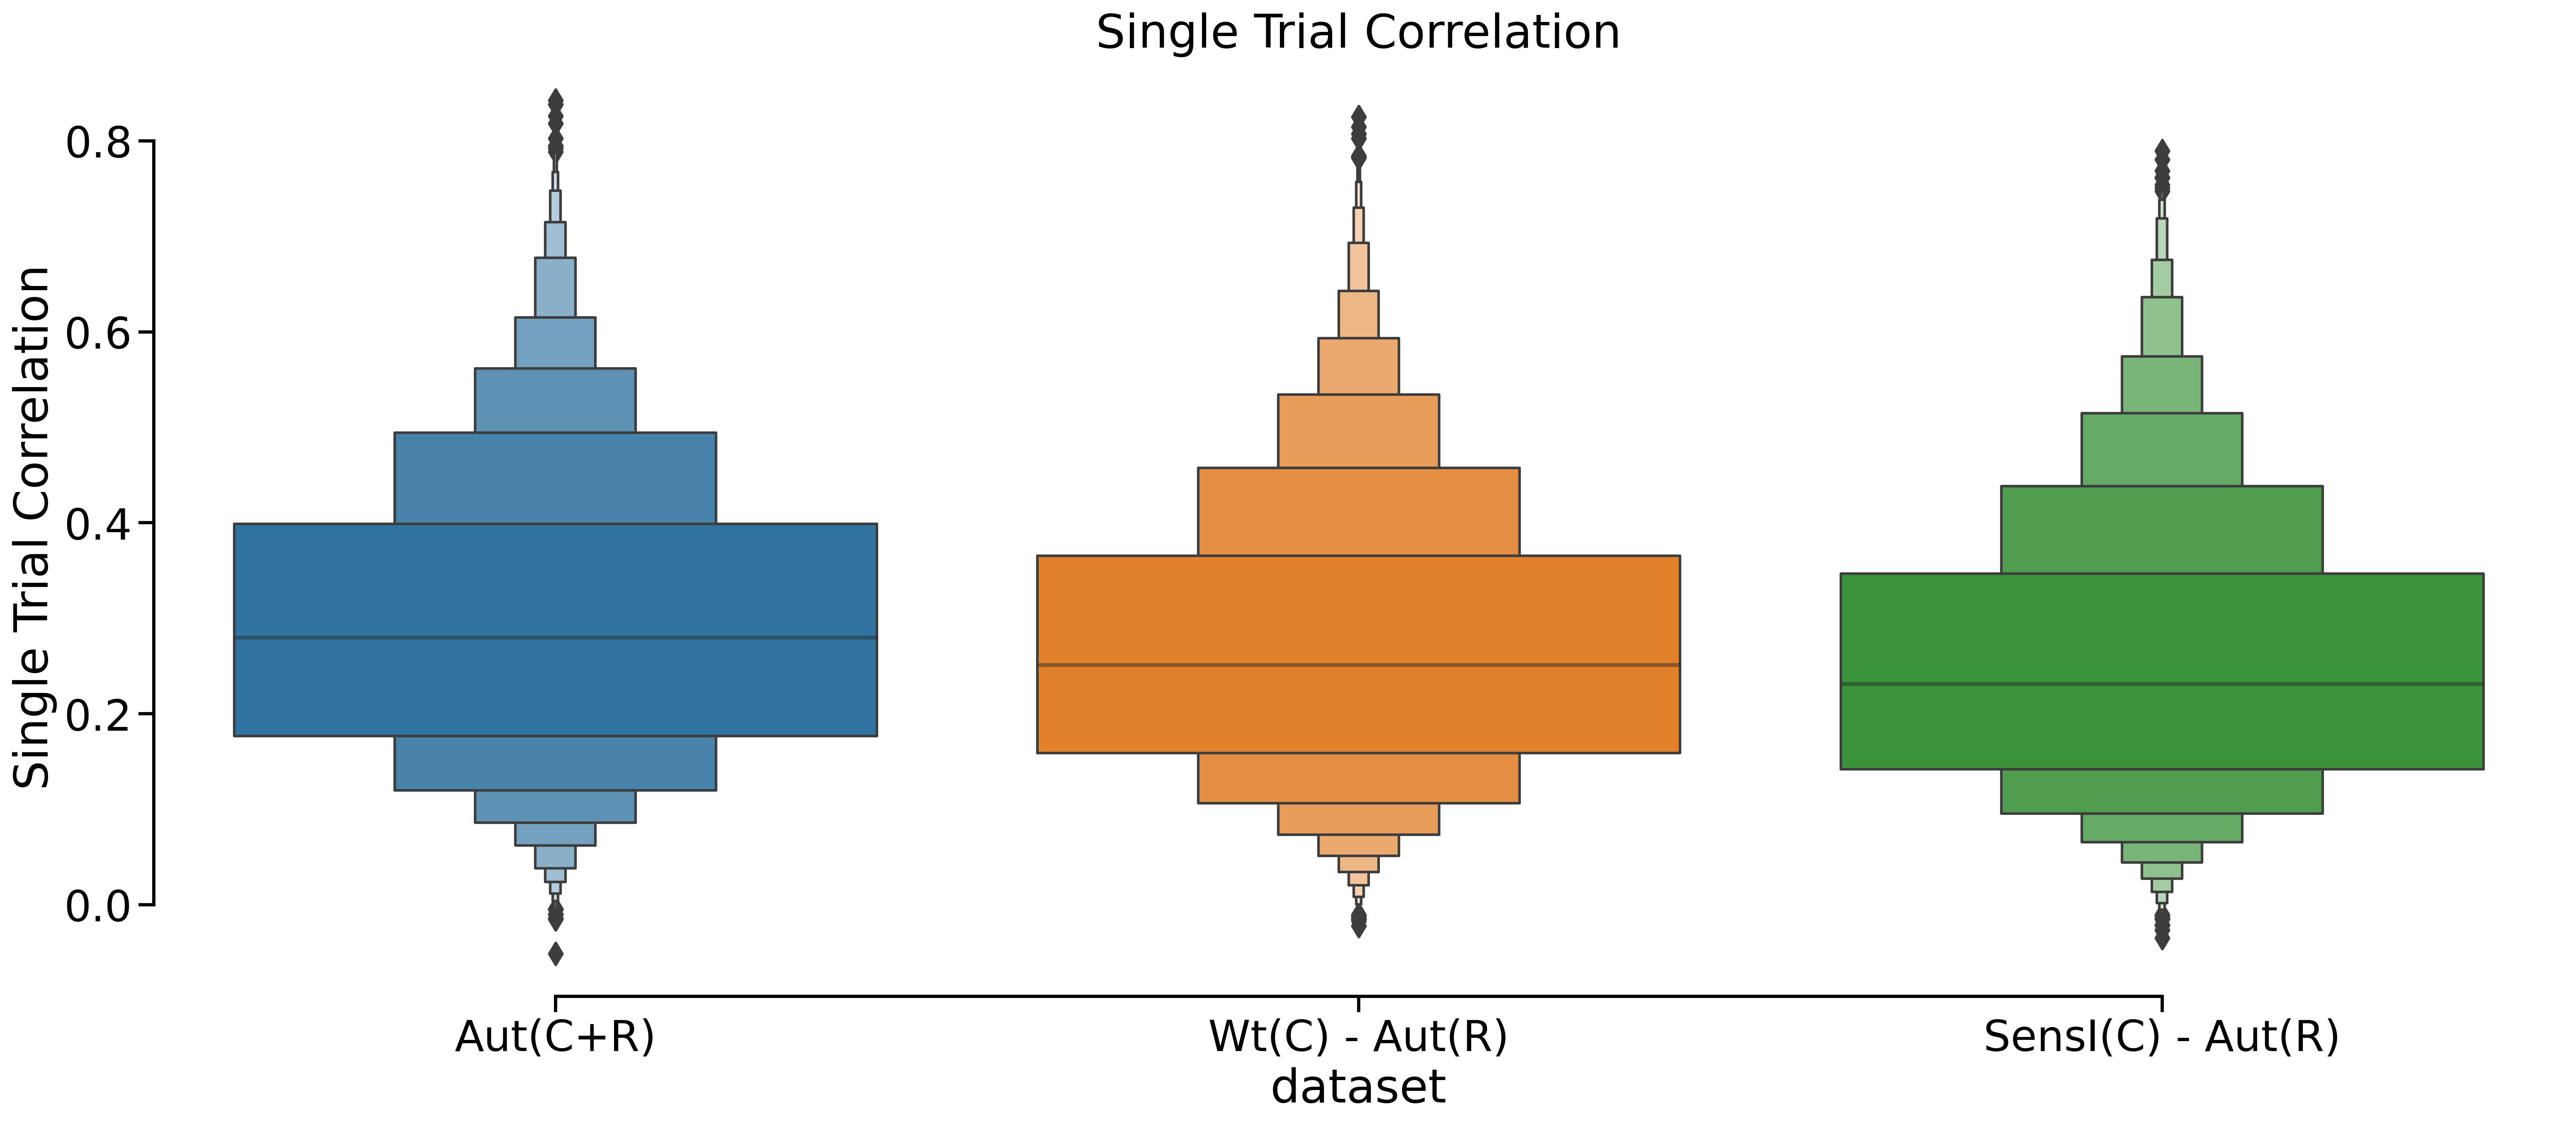

In [14]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df_ar, )
plt.title("Single Trial Correlation")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonSTCTAutR.png", dpi=300)

## Calculating the correlation-to-average for all the models of the cross comparison experiment.

In [15]:
correlation_to_average_a = get_signal_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
correlation_to_average_awt = get_signal_correlations(model_awt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
correlation_to_average_wta = get_signal_correlations(model_wta, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
correlation_to_average_wt = get_signal_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
correlation_to_average_s1 = get_signal_correlations(model_sens1, dataloaders_sens1, tier="test", device="cuda", as_dict=True)
correlation_to_average_s2 = get_signal_correlations(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)
correlation_to_average_sa = get_signal_correlations(model_sa, dataloaders_autistic, tier="test", device="cuda", as_dict=True)


In [16]:
df_cta_awt = get_df_for_scores(session_dict=correlation_to_average_awt, measure_attribute="Correlation to Average")
df_cta_awt["dataset"] = df_cta_awt["dataset"].replace("29028-1-17-1-6-5", "Aut(C) - Wt(R)")
df_cta_wta = get_df_for_scores(session_dict=correlation_to_average_wta, measure_attribute="Correlation to Average")
df_cta_wta["dataset"] = df_cta_wta["dataset"].replace("29027-6-17-1-6-5", "Wt(C) - Aut(R)")
df_cta_a = get_df_for_scores(session_dict=correlation_to_average_a, measure_attribute="Correlation to Average")
df_cta_a["dataset"] = df_cta_a["dataset"].replace("29027-6-17-1-6-5", "Aut(C+R)")
df_cta_wt = get_df_for_scores(session_dict=correlation_to_average_wt, measure_attribute="Correlation to Average")
df_cta_wt["dataset"] = df_cta_wt["dataset"].replace("29028-1-17-1-6-5", "Wt(C+R)")
df_cta_s1 = get_df_for_scores(session_dict=correlation_to_average_s1, measure_attribute="Correlation to Average")
df_cta_s1["dataset"] = df_cta_s1["dataset"].replace("22846-10-16", "SensI(C+R)")
df_cta_s2 = get_df_for_scores(session_dict=correlation_to_average_s2, measure_attribute="Correlation to Average")
df_cta_s2["dataset"] = df_cta_s2["dataset"].replace("23964-4-22", "SensII(C+R)")
df_cta_sa = get_df_for_scores(session_dict=correlation_to_average_sa, measure_attribute="Correlation to Average")
df_cta_sa["dataset"] = df_cta_sa["dataset"].replace("29027-6-17-1-6-5", "SensI(C) - Aut(R)")
df_cta = pd.concat([df_cta_a, df_cta_awt, df_cta_wta, df_cta_wt, df_cta_s1, df_cta_sa, df_cta_s2])

In [17]:
df_cta_ac = pd.concat([df_cta_a, df_cta_awt])
df_cta_wc = pd.concat([df_cta_wt, df_cta_wta])
df_cta_ar = pd.concat([df_cta_a, df_cta_wta, df_cta_sa])

In [18]:
df_cta.groupby("dataset").describe()

Correlation to Average                                \
                                   count      mean       std       min   
dataset                                                                  
Aut(C) - Wt(R)                    7497.0  0.461847  0.212777 -0.147805   
Aut(C+R)                          7744.0  0.575877  0.203424 -0.163900   
SensI(C) - Aut(R)                 7744.0  0.496885  0.205761 -0.088680   
SensI(C+R)                        7344.0  0.565795  0.162521  0.042354   
SensII(C+R)                       8098.0  0.519577  0.184208 -0.119956   
Wt(C) - Aut(R)                    7744.0  0.527221  0.204517 -0.076307   
Wt(C+R)                           7497.0  0.449501  0.215090 -0.191401   

                                                           
                        25%       50%       75%       max  
dataset                                                    
Aut(C) - Wt(R)     0.306346  0.463795  0.615833  0.984167  
Aut(C+R)           0.436897  0.595025  0.732902  0.985118  
SensI(C) - Aut(R)  0.348359  0.503237  0.649379  0.982822  
SensI(C+R)         0.454735  0.578415  0.686713  0.956136  
SensII(C+R)        0.391777  0.524085  0.658141  0.955694  
Wt(C) - Aut(R)     0.382724  0.540543  0.683236  0.972304  
Wt(C+R)            0.290132  0.444770  0.608277  0.980679

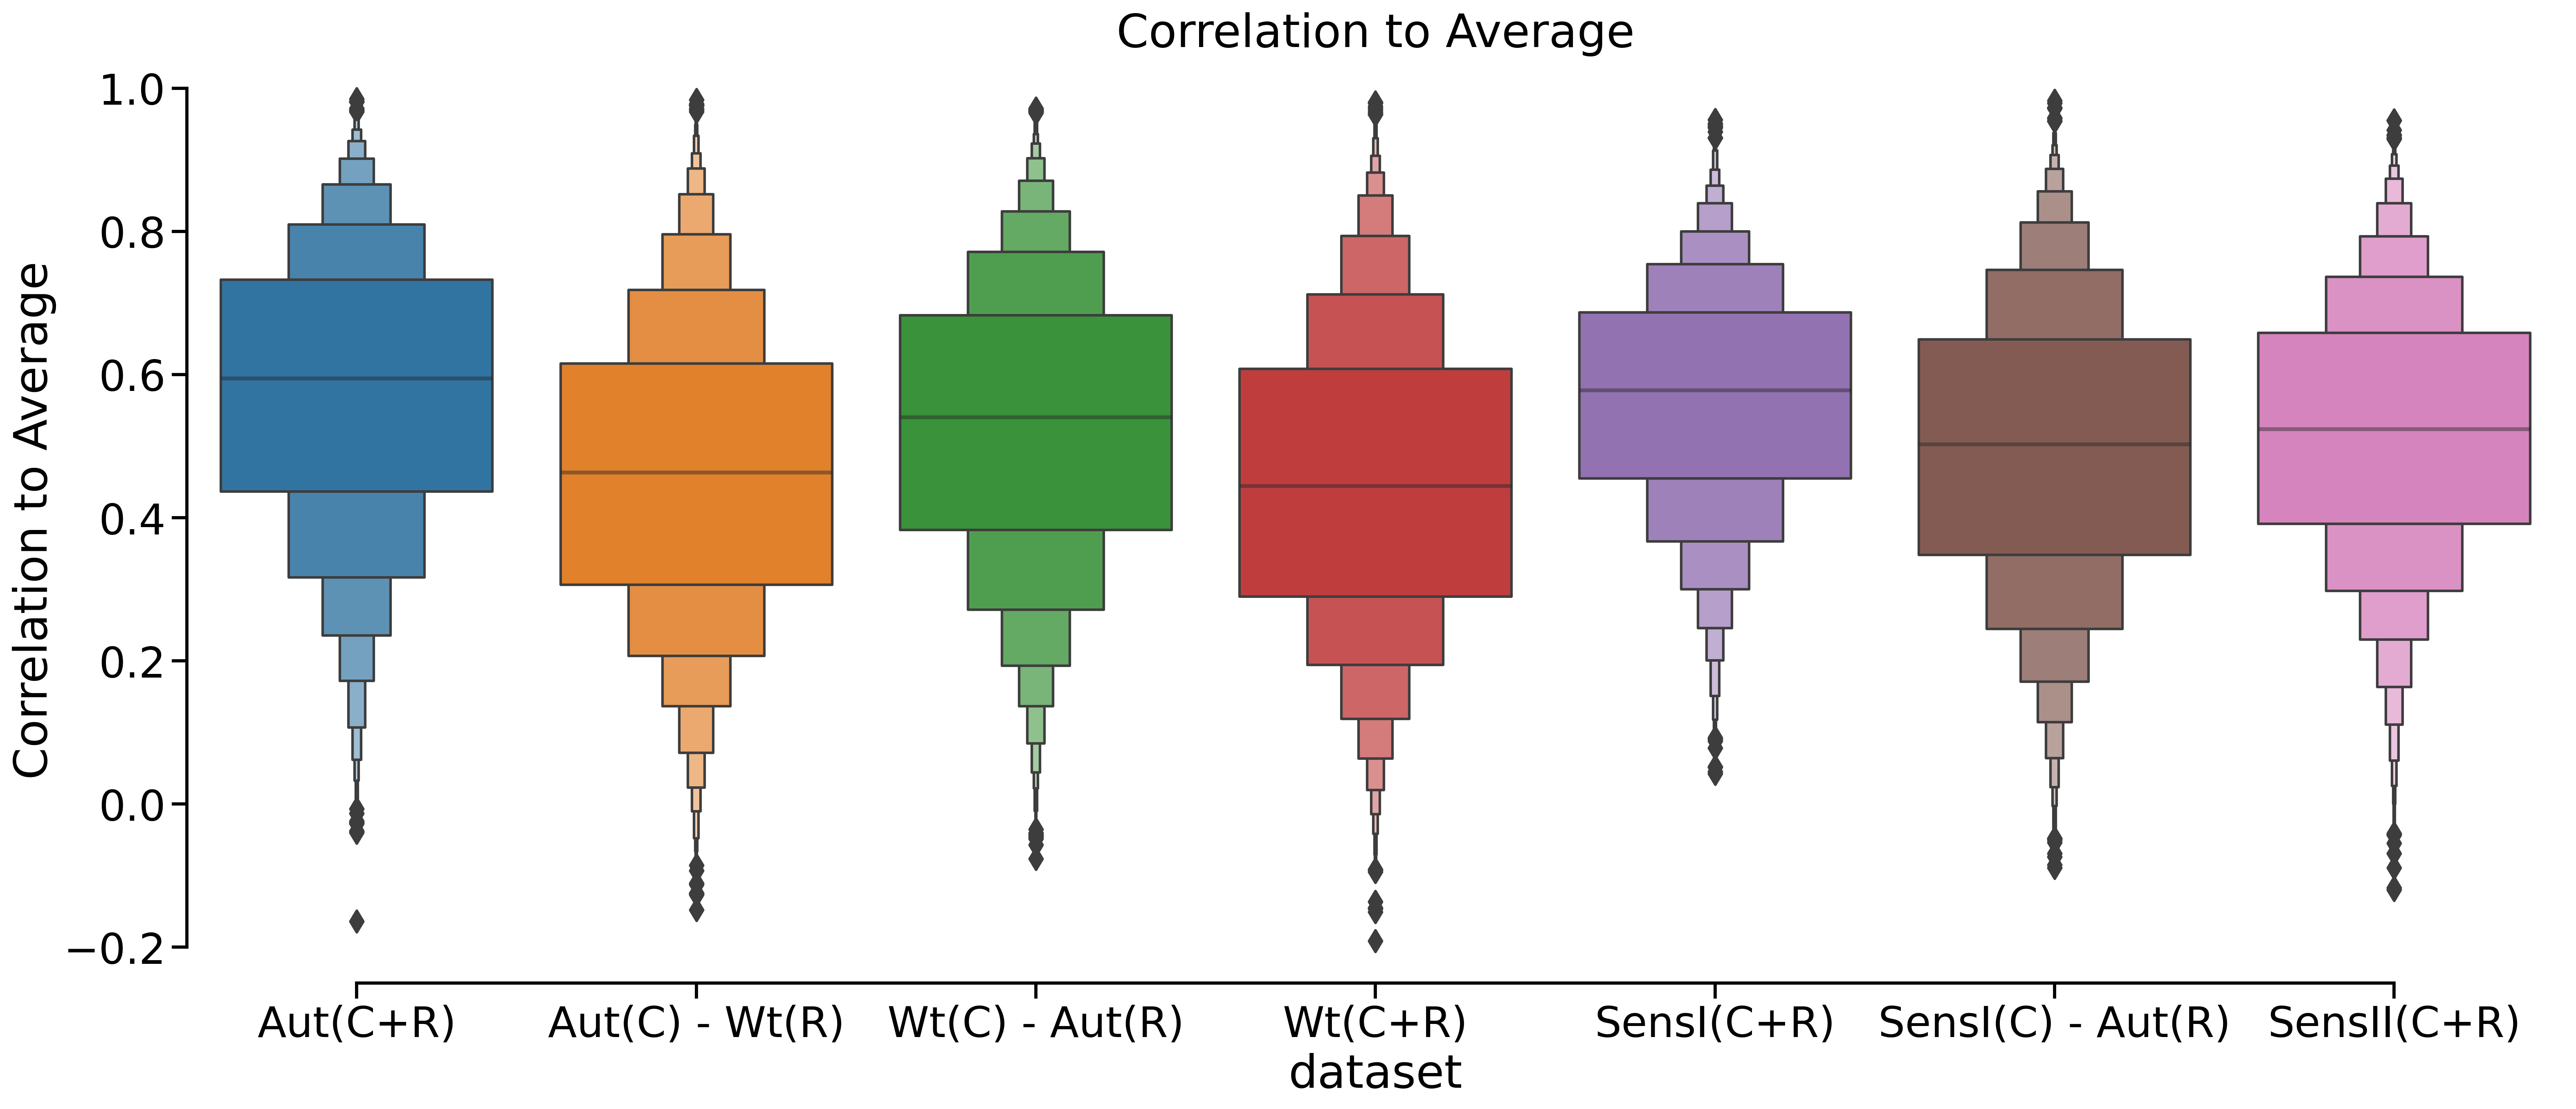

In [19]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Correlation to Average", data=df_cta, )
plt.title("Correlation to Average")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonCTA.png", dpi=300)

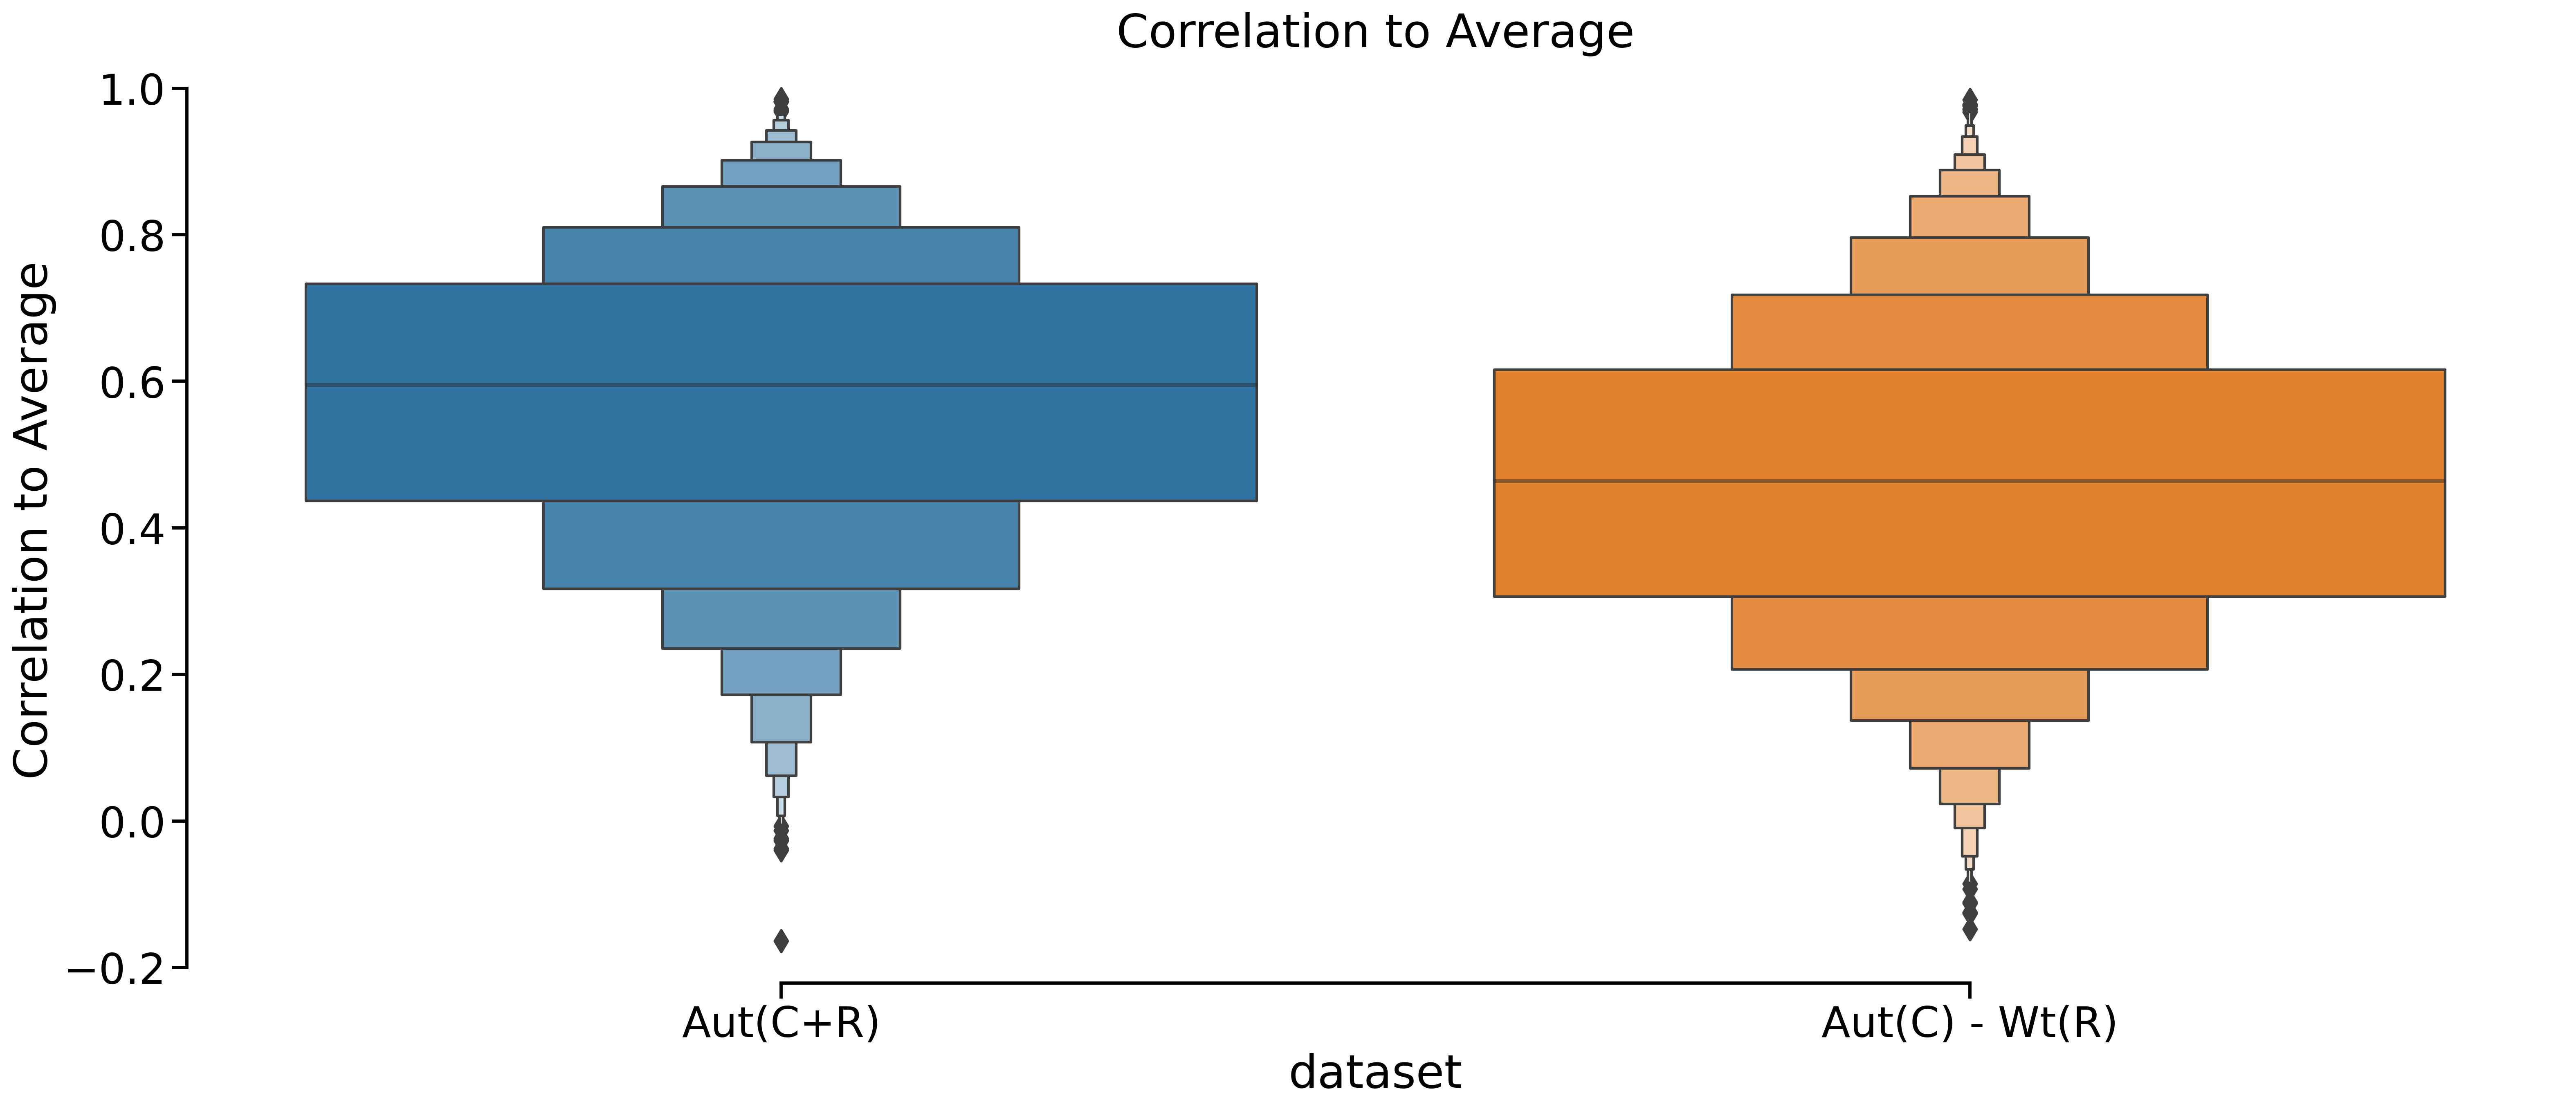

In [20]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Correlation to Average", data=df_cta_ac, )
plt.title("Correlation to Average")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonCTAAutC.png", dpi=300)

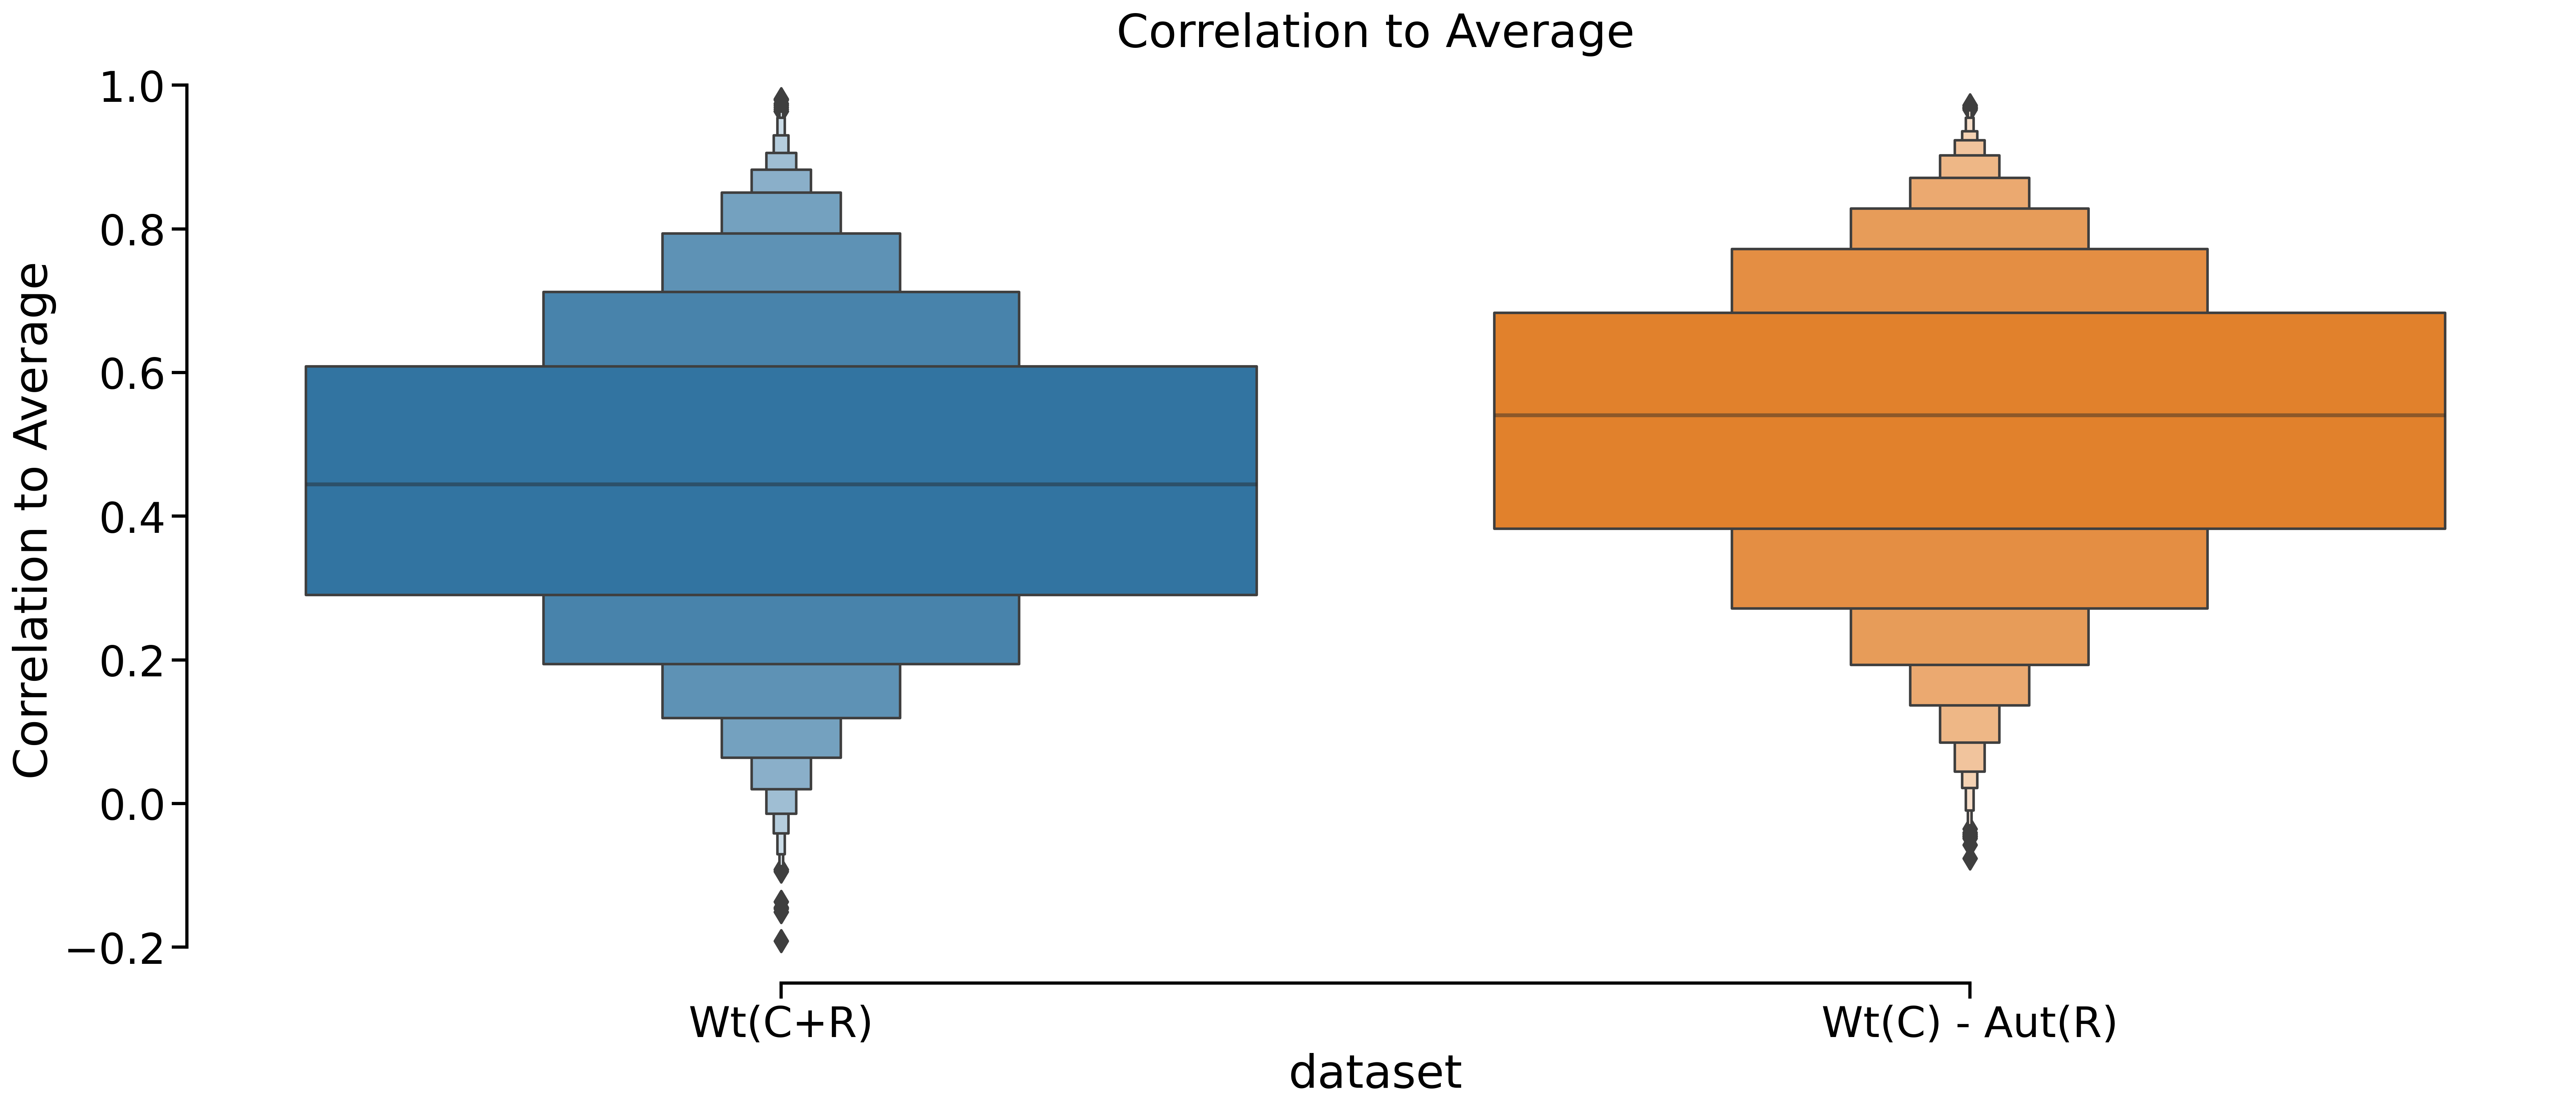

In [21]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Correlation to Average", data=df_cta_wc, )
plt.title("Correlation to Average")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonCTAWtC.png", dpi=300)

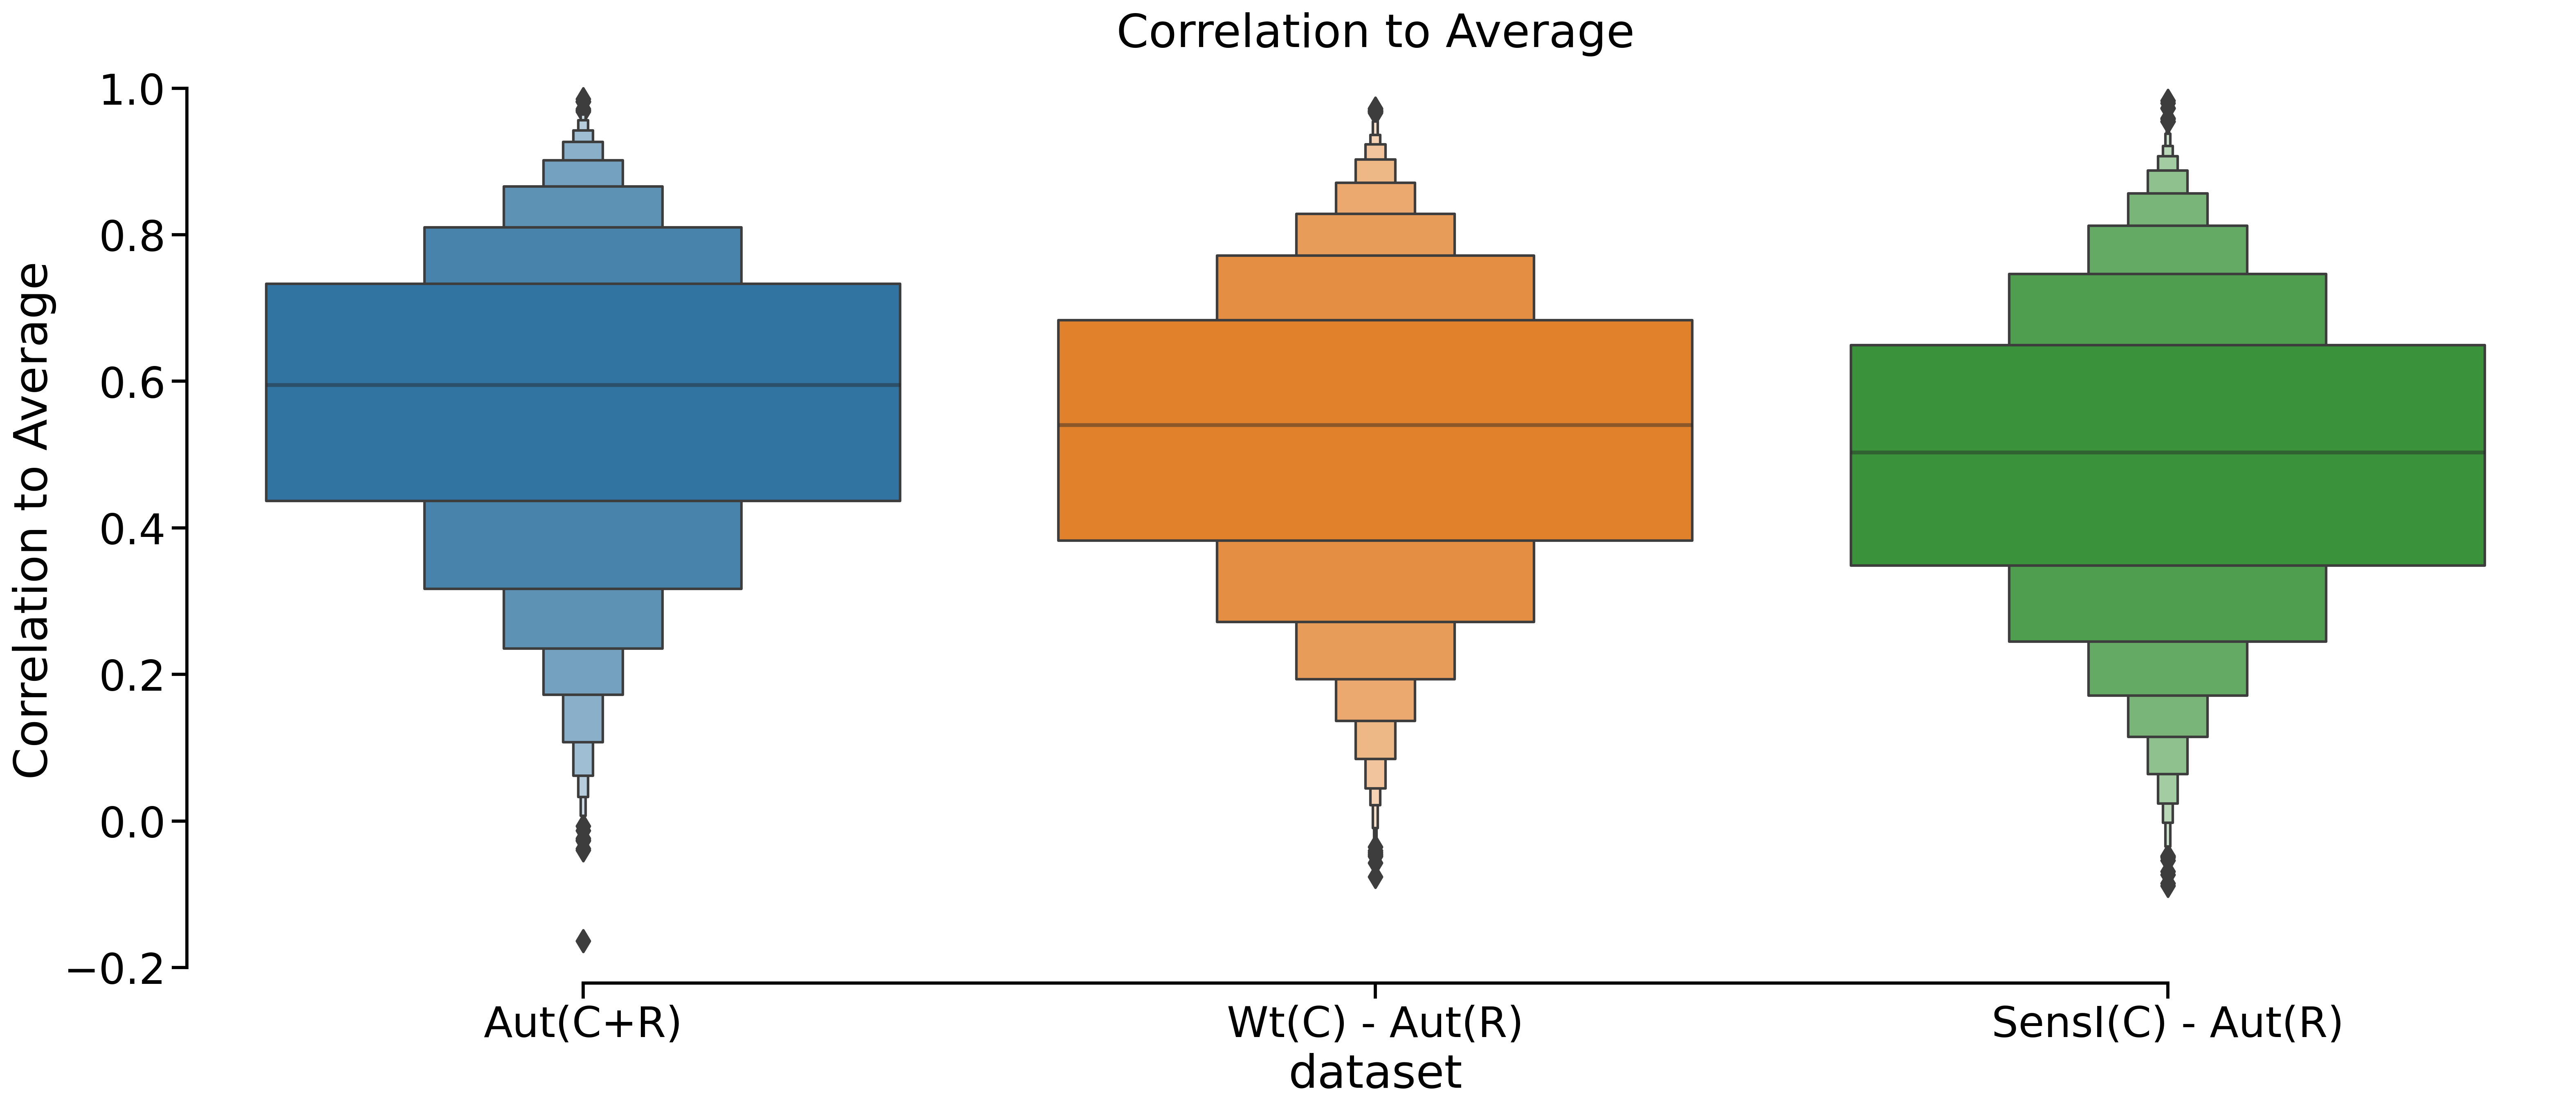

In [22]:
sns.set_context("talk", font_scale=1.5)
fig = plt.figure(figsize=(25,10), dpi=300)
sns.boxenplot(x="dataset", y="Correlation to Average", data=df_cta_ar, )
plt.title("Correlation to Average")
plt.xticks(rotation = 0);
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonCTAAutR.png", dpi=300)

## Calculating the fraction of explainable variance explained for the models of the cross comparison experiment.

In [23]:
feves_a = get_fev(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
feves_awt = get_fev(model_awt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
feves_wta = get_fev(model_wta, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
feves_wt = get_fev(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
feves_s1 = get_fev(model_sens1, dataloaders_sens1, tier="test", device="cuda", as_dict=True)
feves_s2 = get_fev(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)
feves_sa = get_fev(model_sa, dataloaders_autistic, tier="test", device="cuda", as_dict=True)


In [24]:
df_feve_awt = get_df_for_scores(session_dict=feves_awt, measure_attribute="FEVE")
df_feve_awt["dataset"] = df_feve_awt["dataset"].replace("29028-1-17-1-6-5", "Aut(C) - Wt(R)")
df_feve_wta = get_df_for_scores(session_dict=feves_wta, measure_attribute="FEVE")
df_feve_wta["dataset"] = df_feve_wta["dataset"].replace("29027-6-17-1-6-5", "Wt(C) - Aut(R)")
df_feve_a = get_df_for_scores(session_dict=feves_a, measure_attribute="FEVE")
df_feve_a["dataset"] = df_feve_a["dataset"].replace("29027-6-17-1-6-5", "Aut(C+R)")
df_feve_wt = get_df_for_scores(session_dict=feves_wt, measure_attribute="FEVE")
df_feve_wt["dataset"] = df_feve_wt["dataset"].replace("29028-1-17-1-6-5", "Wt(C+R)")
df_feve_s1 = get_df_for_scores(session_dict=feves_s1, measure_attribute="FEVE")
df_feve_s1["dataset"] = df_cta_s1["dataset"].replace("22846-10-16", "SensI(C+R)")
df_feve_s2 = get_df_for_scores(session_dict=feves_s2, measure_attribute="FEVE")
df_feve_s2["dataset"] = df_cta_s2["dataset"].replace("23964-4-22", "SensII(C+R)")
df_feve_sa = get_df_for_scores(session_dict=feves_sa, measure_attribute="FEVE")
df_feve_sa["dataset"] = df_cta_sa["dataset"].replace("29027-6-17-1-6-5", "SensI(C) - Aut(R)")
df_feve = pd.concat([df_feve_a, df_feve_awt, df_feve_wta, df_feve_wt, df_feve_s1, df_feve_sa, df_feve_s2])

In [25]:
df_feve.groupby("dataset").describe()

FEVE                                                    \
                    count      mean       std       min       25%       50%   
dataset                                                                       
Aut(C) - Wt(R)     2533.0  0.419138  0.309198 -2.605925  0.216145  0.409464   
Aut(C+R)           4214.0  0.500109  0.337972 -3.775740  0.319957  0.521747   
SensI(C) - Aut(R)  4214.0  0.374602  0.293727 -3.720923  0.186903  0.364594   
SensI(C+R)         4807.0  0.466044  0.244721 -2.094406  0.322715  0.485162   
SensII(C+R)        4397.0  0.412534  0.303049 -5.084965  0.241903  0.440447   
Wt(C) - Aut(R)     4214.0  0.418769  0.311339 -5.020734  0.227409  0.411042   
Wt(C+R)            2533.0  0.410034  0.317348 -1.217380  0.179466  0.388777   

                                       
                        75%       max  
dataset                                
Aut(C) - Wt(R)     0.615324  1.641764  
Aut(C+R)           0.701236  2.090922  
SensI(C) - Aut(R)  0.562449  1.933742  
SensI(C+R)         0.633859  1.055854  
SensII(C+R)        0.607943  1.147230  
Wt(C) - Aut(R)     0.606877  1.990058  
Wt(C+R)            0.614748  1.829017

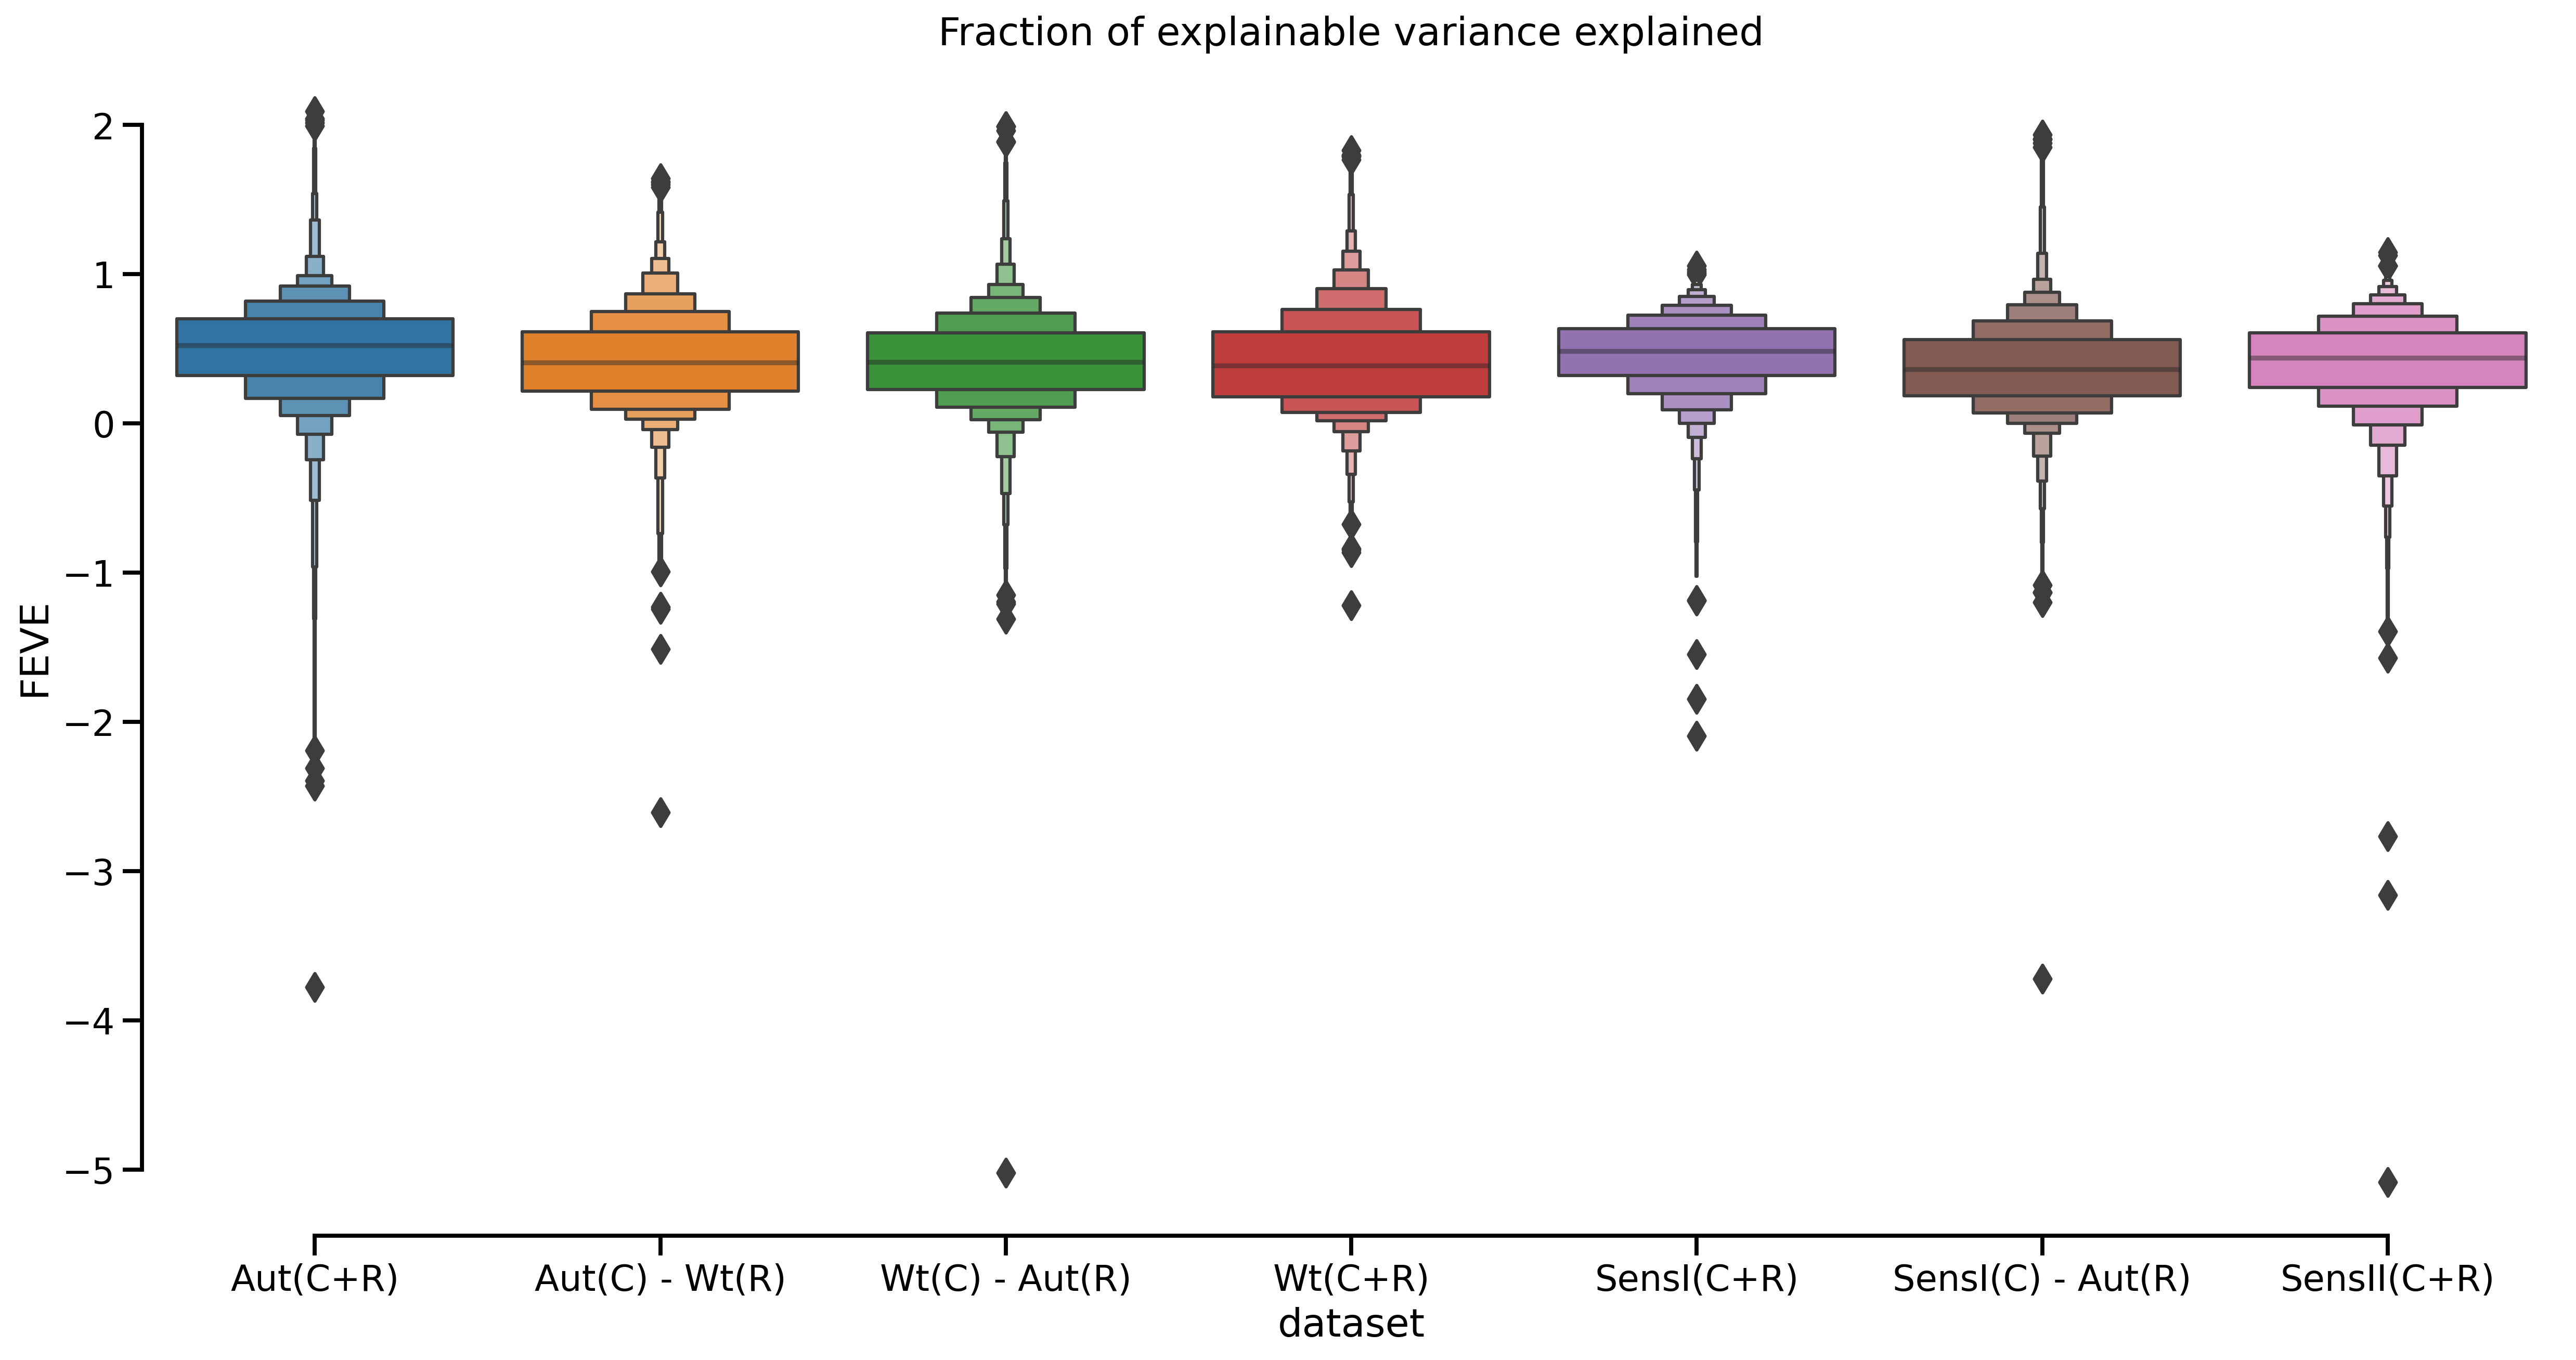

In [26]:
sns.set_context("talk", font_scale=1.0)
fig = plt.figure(figsize=(20,10), dpi=300)
sns.boxenplot(x="dataset", y="FEVE", data=df_feve, )
plt.title("Fraction of explainable variance explained")
plt.xticks(rotation = 0)
sns.despine(trim=True)
fig.savefig("Plots/CrossComparisonFEVE.png", dpi=300)